In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from noise import NoiseMap_LB_Freq
from tqdm import tqdm
from database import surveys

In [3]:
base = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD'

In [4]:
lensed_map_dir = os.path.join(base,'CMB_Lensed_Maps')
dust_map_dir = os.path.join(base,'Foregrounds','Dust')
sync_map_dir = os.path.join(base,'Foregrounds','Synchrotron')

In [5]:
survey = surveys().get_table_dataframe('LITEBIRD')

2021-10-28 05:08:35,977 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2021-10-28 05:08:35,978 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-10-28 05:08:35,980 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2021-10-28 05:08:35,980 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-10-28 05:08:35,981 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='view' ORDER BY name
2021-10-28 05:08:35,981 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-10-28 05:08:35,983 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("LITEBIRD")
2021-10-28 05:08:35,983 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-10-28 05:08:35,985 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2021-10-28 05:08:35,986 INFO sqlalchemy.engine.Engine [raw sql] ('LITEBIRD',)
2021-10-28 05:08:35,987 INFO sq

In [9]:
nside = 512
N = NoiseMap_LB_Freq('Tes',nside,np.array(survey.depth_p),np.array(survey.frequency),1)

In [13]:
def get_cmb(idx):
    fname = os.path.join(lensed_map_dir,f"cmbonly_{idx}.fits")
    return hp.ud_grade(hp.read_map(fname,(0,1,2)),nside)

def get_dust(v):
    fname = os.path.join(dust_map_dir,f"d0_{int(v)}.fits")
    return hp.ud_grade(hp.read_map(fname,(0,1,2)),nside)
def get_sync(v):
    fname = os.path.join(sync_map_dir,f"s0_{int(v)}.fits")
    return hp.ud_grade(hp.read_map(fname,(0,1,2)),nside)

In [14]:
freqs = np.array(survey.frequency)
fwhm = np.array(survey.fwhm)
def total_map_v(idx,i):
    return hp.smoothing(get_cmb(idx) + get_dust(freqs[i])+ get_sync(freqs[i]),np.radians(fwhm[i]/60)) + N.get_maps_v(idx,i)

In [15]:
maps = []
for i in tqdm(range(len(freqs)),desc="Generating Maps",unit="freq"):
    maps.append(total_map_v(0,i))

Generating Maps: 100%|██████████| 15/15 [08:46<00:00, 35.13s/freq]


In [10]:
len(maps)

15

In [12]:
from fgbuster import (CMB, Dust, Synchrotron,
                      basic_comp_sep,
                      get_observation, get_instrument)

In [13]:
instrument = get_instrument('LiteBIRD')

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/fgbuster/observation_helpers.py:97: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  return df.dropna(1, 'all')


In [14]:
components = [CMB(), Dust(150.,20,1.54), Synchrotron(20.,-3.,70.,)]

In [15]:
from fgbuster import basic_comp_sep,harmonic_ilc

In [16]:
bins = np.arange(1000) * 10
result = harmonic_ilc(components, instrument, np.array(maps),bins,iter=10)

In [17]:
result.keys()

dict_keys(['s', 'cl_in', 'cl_out', 'fsky', 'W'])

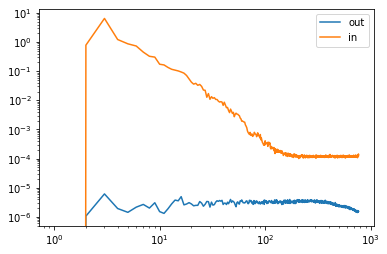

In [18]:
plt.loglog(result.cl_out[0][2],label='out')
plt.loglog(result.cl_in[0][2],label='in')
plt.legend()